In [14]:
import os
import copy
import json
import argparse

import numpy as np
from tqdm import tqdm
import tensorflow as tf

from network_models.dcgan_policy import DCGANPolicy
from network_models.sngan_policy import SNGANPolicy
from network_models.dcgan_discriminator import DCGANDiscriminator
from network_models.sngan_discriminator import SNGANDiscriminator
from algo.ppo import PPOTrain
from algo.trpo import TRPOTrain
from utils import generator

import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
model_dir = './out/ppo_1'
ckpt_path = os.path.join(model_dir, 'model-300.ckpt')
with open(os.path.join(model_dir, 'config.json'), 'r') as f:
    config = json.load(f)
obs_size = 64
obs_shape = [3, 64, 64, 1]
gpu = '0'
if not 'g_sn' in config.keys():
    config['g_sn'] = ''
    config['d_sn'] = ''

In [3]:
config

{'D_step': 1,
 'G_step': 3,
 'algo': 'ppo',
 'batch_size': 32,
 'c_entropy': 0.01,
 'c_l1': 1.0,
 'c_vf': 0.2,
 'd_sn': '',
 'data': '../../dataset/mnist_test_seq.npy',
 'g_sn': '',
 'gamma': 0.95,
 'initia_learning_rate': 0.0001,
 'iteration': 300,
 'leaky': True,
 'lr_schedules': 100,
 'spectral normalization': False,
 'vf_clip': ''}

In [4]:
data = np.load(config['data'])
gen = generator(data,
                batch_size=config['batch_size'],
                img_size=obs_size)

In [5]:
if not config['g_sn']:
    print('Building DCGAN Generator as Policy Network')
    # Build policy network
    Policy = DCGANPolicy(
            'policy',
            obs_shape=obs_shape,
            batch_size=config['batch_size'],
            decode=True,
            leaky=config['leaky'])
    Old_Policy = DCGANPolicy(
            'old_policy',
            obs_shape=obs_shape,
            batch_size=config['batch_size'],
            decode=True,
            leaky=config['leaky'])
else:
    print('Building SNGAN Generator as Policy Network')
    Policy = SNGANPolicy(
            'policy',
            obs_shape=obs_shape,
            batch_size=config['batch_size'],
            decode=True)
    Old_Policy = SNGANPolicy(
            'old_policy',
            obs_shape=obs_shape,
            batch_size=config['batch_size'],
            decode=True)

# Build reinforcement agent
if config['algo'] == 'ppo':
    print('Building PPO Agent')
    Agent = PPOTrain(
            Policy,
            Old_Policy,
            obs_shape=obs_shape,
            gamma=config['gamma'],
            c_vf=config['c_vf'],
            c_entropy=config['c_entropy'],
            c_l1=config['c_l1'],
            obs_size=obs_size,
            vf_clip=config['vf_clip'])
elif config['algo'] == 'trpo':
    print('Building TRPO Agent')
    Agent = TRPOTrain(
            Policy,
            Old_Policy,
            obs_shape=obs_shape,
            gamma=config['gamma'],
            c_vf=config['c_vf'],
            c_entropy=config['c_entropy'],
            c_l1=config['c_l1'],
            obs_size=obs_size,
            vf_clip=config['vf_clip'])
else:
    raise ValueError('invalid algo name')

# Build Discriminator
if config['d_sn']:
    print('Building SNGAN Discriminator')
    D = SNGANDiscriminator(obs_shape=obs_shape,
        batch_size=config['batch_size'])
else:
    print('Building DCGAN Discriminator')
    D = DCGANDiscriminator(obs_shape=obs_shape,
        batch_size=config['batch_size'],
        leaky=config['leaky'])

Building DCGAN Generator as Policy Network
Building PPO Agent
Building DCGAN Discriminator


In [10]:
# Create tensorflow saver
saver = tf.train.Saver()
# session config
sess_config = tf.ConfigProto(
        gpu_options=tf.GPUOptions(
            visible_device_list=gpu,
            allow_growth=True))
with tf.Session(config=sess_config) as sess:
    saver.restore(sess, ckpt_path)
    expert_batch = next(gen)
    agent_batch = expert_batch[:, :3, :, :, :]
    pred_batch = Policy.inference(agent_batch)

INFO:tensorflow:Restoring parameters from ./out/ppo_1/model-300.ckpt


In [46]:
img = np.reshape(pred_batch[0], (64, 64))

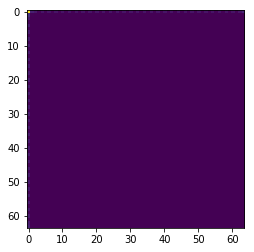

In [47]:
plt.imshow(img*255)